In [4]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [5]:
import os, gc, pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from colorama import Fore, Back, Style
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import warnings
warnings.simplefilter('ignore')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error

DATA_DIR = "/kaggle/input/open-problems-multimodal/"
FP_CELL_METADATA = os.path.join(DATA_DIR,"metadata.csv")

FP_CITE_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_cite_inputs.h5")
FP_CITE_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_cite_targets.h5")
FP_CITE_TEST_INPUTS = os.path.join(DATA_DIR,"test_cite_inputs.h5")

FP_MULTIOME_TRAIN_INPUTS = os.path.join(DATA_DIR,"train_multi_inputs.h5")
FP_MULTIOME_TRAIN_TARGETS = os.path.join(DATA_DIR,"train_multi_targets.h5")
FP_MULTIOME_TEST_INPUTS = os.path.join(DATA_DIR,"test_multi_inputs.h5")

FP_SUBMISSION = os.path.join(DATA_DIR,"sample_submission.csv")
FP_EVALUATION_IDS = os.path.join(DATA_DIR,"evaluation_ids.csv")

In [2]:
!pip install --quiet tables

In [4]:
df_cell = pd.read_csv(FP_CELL_METADATA)
df_cell_cite = df_cell[df_cell.technology=="citeseq"]
df_cell_multi = df_cell[df_cell.technology=="multiome"]
df_cell_cite.shape, df_cell_multi.shape

((119651, 5), (161877, 5))

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
df_meta = pd.read_csv(FP_CELL_METADATA, index_col='cell_id')
display(df_meta)

,day,donor,cell_type,technology
cell_id,,,,
c2150f55becb,2,27678,HSC,citeseq
65b7edf8a4da,2,27678,HSC,citeseq
c1b26cb1057b,2,27678,EryP,citeseq
917168fa6f83,2,27678,NeuP,citeseq
2b29feeca86d,2,27678,EryP,citeseq
...,...,...,...,...
96a60b026659,10,31800,hidden,multiome
d493e546991e,10,31800,hidden,multiome
05666c99aa48,10,31800,hidden,multiome


In [3]:
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS)
display(df_cite_train_x.head())
print('Shape:', df_cite_train_x.shape)
print("Missing values:", df_cite_train_x.isna().sum().sum())
print("Genes which never occur in train:", (df_cite_train_x == 0).all(axis=0).sum())
print(f"Zero entries in train: {(df_cite_train_x == 0).sum().sum() / df_cite_train_x.size:.0%}")
cite_gene_names = list(df_cite_train_x.columns)

NameError: name 'pd' is not defined

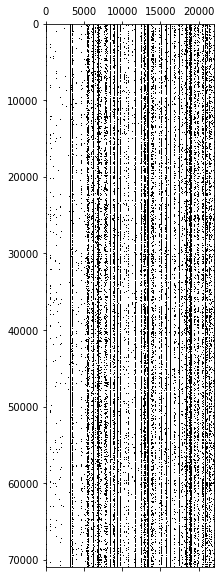

In [14]:
plt.figure(figsize=(40, 10))
plt.spy(df_cite_train_x(:5000))
plt.show()
#Twhe distribution of the zeros can be visualized with the pyplot spy() function. This function plots a 
#black dot for every nonzero entry of the array. The resulting image shows us that the differences between the 
#columns are substantial: some columns are almost white (i.e., they contain mostly zeros), others are dark 
#(i.e., they contain a lot of nonzero values). The rows of the matrix look homogeneous.
#Insight: Maybe we can exploit the column differences for feature selection.

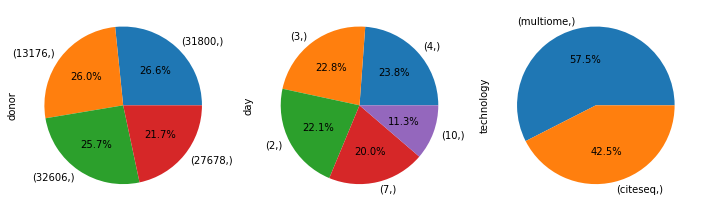

In [11]:
fig, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
for i, col in enumerate(["donor", "day", "technology"]):
    _= df_meta[[col]].value_counts().plot.pie(ax=axarr[i], autopct='%1.1f%%', ylabel=col)
    
#As we can see, the cell data is pretty balanced. We have almost an equal number of cells from each donor 
#(the big numbers in the first picture are the donor ids). Also, the days of the experiment were fairly balanced. 
#The last day, day 10, only receives an 11% share of the cells. Day 10 is also the only day not present in the train 
#data at all! Also, the train set does not contain any data from donor 27678!

#We have slightly more data available for the multinome test. It is not the worst since our model also has to predict
#many more features for that test.

#The distribution of data in general is pretty well balanced (e. g., the number of tests taken / test / day is 
#well distributed).

In [7]:
START = int(1e4)
STOP = START+1000
df_cite_train_x = pd.read_hdf(FP_CITE_TRAIN_INPUTS,start=START,stop=STOP)
print(f"Values for gene expression range from {df_cite_train_x.min().min():.2f} to {df_cite_train_x.max().max():.2f}")

# get data about non-zero values
min_cells_non_zero_y = df_cite_train_x.gt(0).sum(axis=1).min()
max_cells_non_zero_y = df_cite_train_x.gt(0).sum(axis=1).max()
sum_non_zero_values_y = df_cite_train_x.sum().sum()
count_non_zero_values_y = df_cite_train_x.gt(0).sum().sum()
average_non_zero_per_gene_y = df_cite_train_x[df_cite_train_x.gt(0)].count(axis = 1).mean()

print(f"Each cell has at least {min_cells_non_zero_y} genes with non-zero gene expression values and a maximum of {max_cells_non_zero_y}.")
print(f"On average there are {round(average_non_zero_per_gene_y)} genes with non-zero gene expression values in each cell.")
print(f"The average non-zero value for gene expression is about {sum_non_zero_values_y / count_non_zero_values_y:.2f}.")

# investigate standard deviation of features
std_dev_of_genes_y = df_cite_train_x.std()

# ignore genes that are only accessible in a single cell
std_dev_of_genes_without_singles_y = std_dev_of_genes_y[df_cite_train_x.gt(0).sum().gt(1)]
print(f"The standard deviation of gene expression values is between {std_dev_of_genes_without_singles_y.min():.2f} and {std_dev_of_genes_without_singles_y.max():.2f}.\nThe average standard deviation is {std_dev_of_genes_without_singles_y.mean():.2f}")

Values for gene expression range from 0.00 to 11.29
Each cell has at least 2234 genes with non-zero gene expression values and a maximum of 7319.
On average there are 5003 genes with non-zero gene expression values in each cell.
The average non-zero value for gene expression is about 4.39.
The standard deviation of gene expression values is between 0.14 and 2.88.
The average standard deviation is 1.12


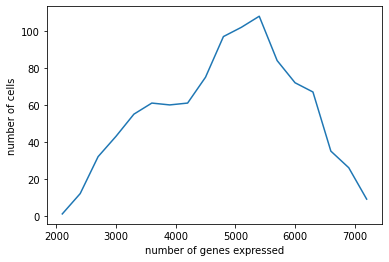

In [8]:
s = df_cite_train_x.gt(0).sum(axis = 1)
counts = s.groupby(lambda x: s[x] // 300).count()
counts.index = counts.index * 300

fig, ax = plt.subplots()
ax.plot(counts.index, counts.values)
ax.set_xlabel('number of genes expressed')
ax.set_ylabel('number of cells')
plt.show()